In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as transforms


In [2]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# Define the transformations for both training and testing sets
transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



# Create the CIFAR-10 datasets with the specified transformations
train_set = CIFAR10(root='.', train=True, transform=transform, download=True)
test_set = CIFAR10(root='.', train=False, transform=transform)

# Accessing actual labels
actual_labels = train_set.classes


train_loader = DataLoader(train_set, batch_size=100, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=4)


Files already downloaded and verified


In [3]:
actual_labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [4]:
def show_images_batch(images, labels, class_names, display_batch):
    batch_size = display_batch
    columns = 4  # You can adjust the number of columns based on your preference
    rows = (batch_size + columns - 1) // columns

    fig, axs = plt.subplots(rows, columns, figsize=(12, 2 * rows))
    axs = axs.flatten()

    for i in range(batch_size):
        image, label = images[i], labels[i]
        class_name = class_names[label.item()]

        axs[i].imshow(transforms.ToPILImage()(image))  # Convert tensor to PIL Image for display
        axs[i].set_title(f'Label: {class_name}')
        axs[i].axis('off')

    plt.show()

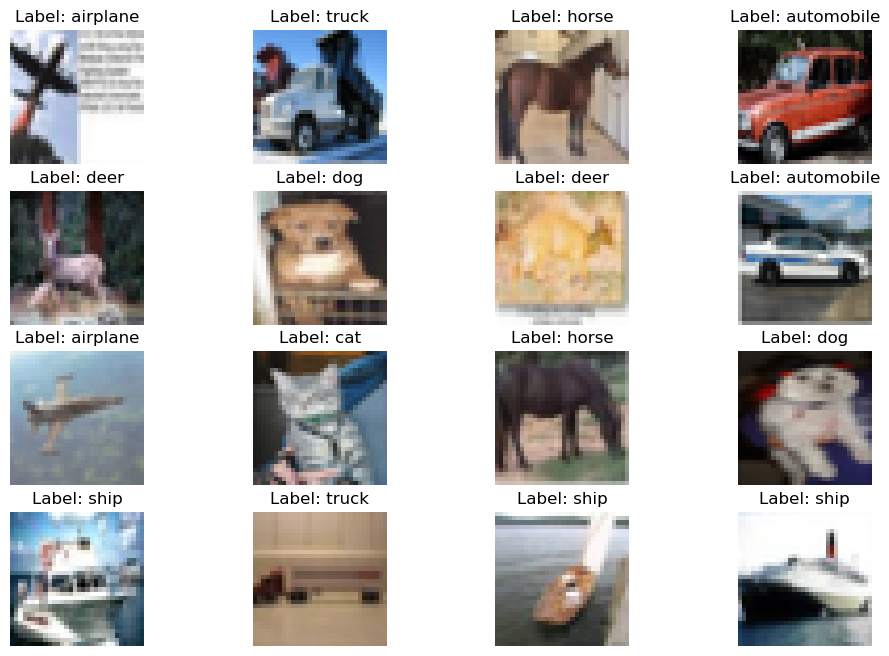

In [5]:
# Assuming your dataset has a 'classes' attribute containing class names
class_names = train_set.classes

display_batch = 16 # Number of images to display from batch

images, labels = next(iter(train_loader))
show_images_batch(images, labels, class_names, display_batch)

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(  # takes in a 16x14x14
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(2048, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [7]:
# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Instantiate the model and move it to the specified device
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.01)

In [9]:
EPOCHS = 201
import time
for epoch in tqdm(range(EPOCHS)):
    totalloss = 0
    for batch, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)
        predictions = model(X)
        loss = criterion(predictions, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        # Using .item() to avoid storing loss tensors with an attached computation graph
        totalloss += loss.item()
    if epoch % 20 == 0:
        totalloss /= len(train_loader)
        print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {totalloss: .4f}")
        
        testloss = 0

        with torch.no_grad():
            for X, y in test_loader:
                X = X.to(device)
                y = y.to(device)
                pred = model(X)
                testloss += criterion(pred, y).item()
            testloss /= len(test_loader)
        
        print(f"Epoch {epoch + 1}/{EPOCHS}, Test Loss: {testloss: .4f}")

  0%|                                                   | 0/201 [00:00<?, ?it/s]

Epoch 1/201, Train Loss:  1.8917


  0%|▏                                          | 1/201 [00:03<12:07,  3.64s/it]

Epoch 1/201, Test Loss:  1.6707


  2%|▊                                          | 4/201 [00:09<07:44,  2.36s/it]


KeyboardInterrupt: 